### HR Budget Optimization Model
**Objectvie**  
$$ Minimize \sum_{d \in D} \sum_{r \in R_{d}}B_{d,r}$$         
Here, $B_{d,r}$is the budget allocated for role $r$ in department $d$. 
The total budget is the sum of the budgets for all roles in all departments.  

**Constraints**            
1. Employee Satisfaction Constraint      
$$S_{d,r,g} \ge S_{min} \quad \forall d \in D, r \in R_{d}, g \in G $$    
$S_{d,r,g}$ is the satisfaction score for role $r$ in department $d$ for demographic group $g$.       
​$S_{min}$ is the minimum acceptable satisfaction score.      
2. Headcount Balance      
$$\sum_{r \in R_{d}} H_{d,r} = H_{d} \quad \forall d \in D$$      
$H_{d,r}$ is the headcount for role $r$ in department $d$.          
$H_{d}$ is the total headcount required for department $d$.     
3. Attrition Impact
$$A_{d,r} \times H_{d,r} \le attrition_threshold \quad \forall d \in D, r \in R_{d}$$     
$A_{d,r}$ is the attrition rate for role $r$ in department $d$.           
The attrition impact is calculated by multiplying the attrition rate by the headcount for each role.        
attrition_threshold is the maximum acceptable attrition impact.        





### Loading the data & libraries

In [389]:
import pandas as pd # for data manipulation
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for plotting visualizations
import seaborn as sns # for plotting visualizations
import factor_analyzer as factor # for factor analysis
import statsmodels.api as sm # for statistical modeling
from sklearn.decomposition import PCA # for principal component analysis
from sklearn.preprocessing import StandardScaler # for standardizing data
from statsmodels.stats.outliers_influence import variance_inflation_factor # for multicollinearity
df = pd.read_csv('Employee_Attrition.csv')

### Reviewing Sata Structure

In [390]:
df.head(0)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [391]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [392]:
#check for missing values
df.isnull().sum()
#three ways to handle missing values
#1.Removing rows/columns with missing values
#2.Filling missing values with a specific value (e.g., mean, median, mode)
#3.Imputing missing values based on other data

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [393]:
#check for duplicates
df.duplicated().sum()

0

In [394]:
# Convert data type 'MonthlyIncome' to float
df.loc[:, 'MonthlyIncome'] = df['MonthlyIncome'].astype(float)

# Add a new column named annual salary for each employee, the value is monthlyincome * 12
df.loc[:, 'AnnualSalary'] = df['MonthlyIncome']*12

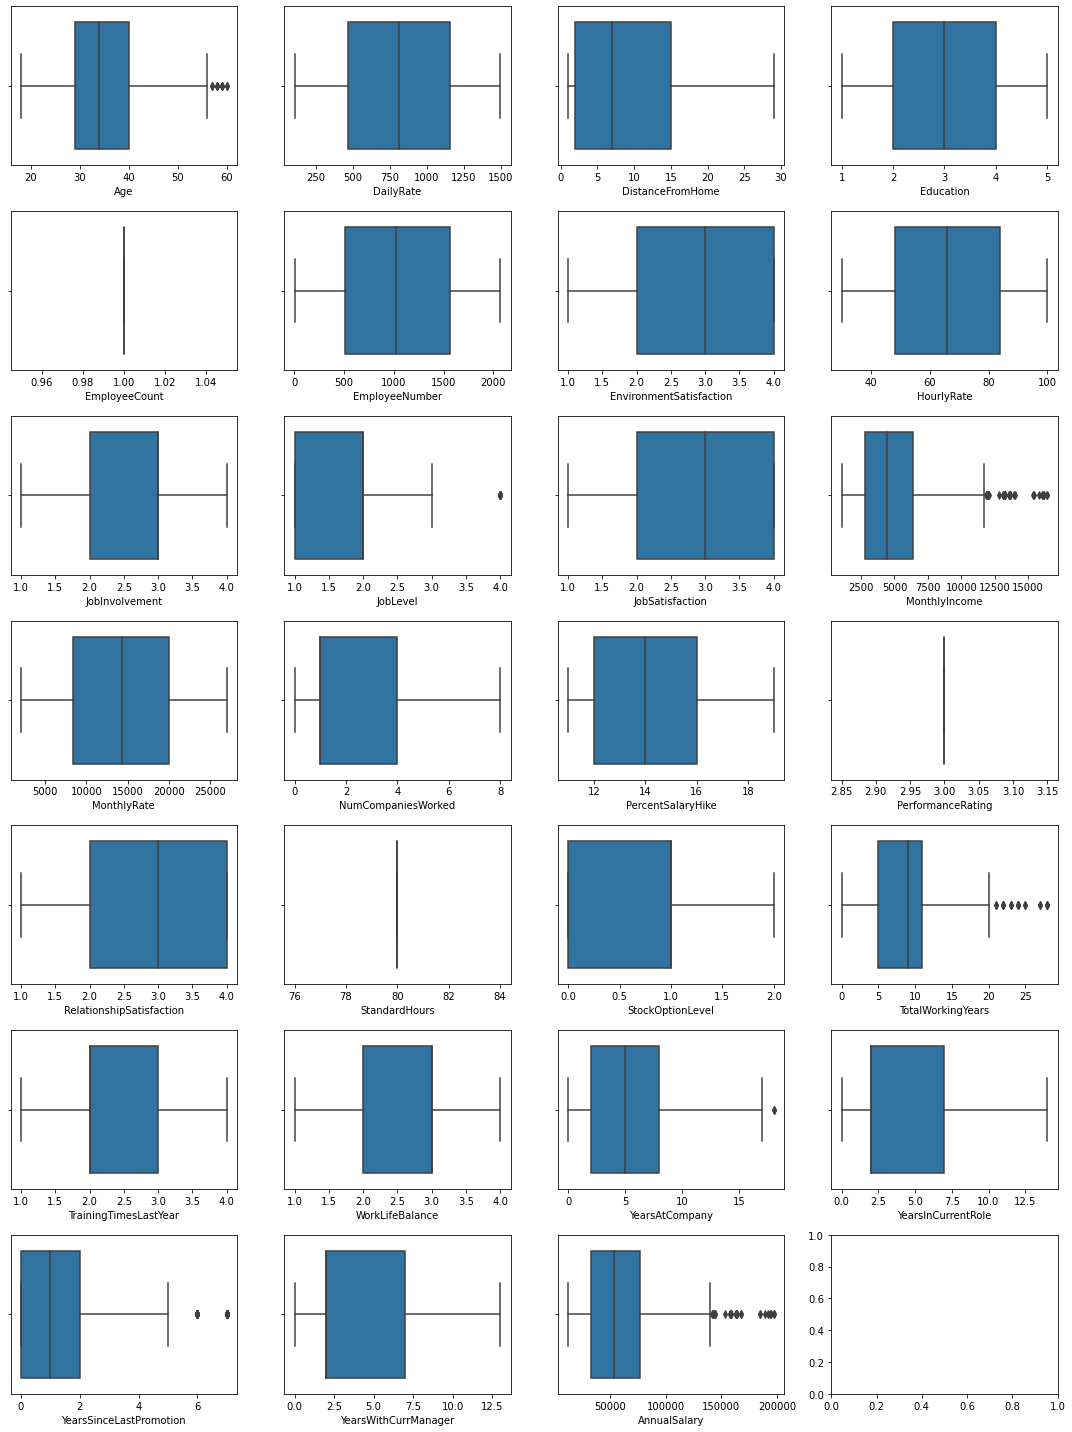

In [395]:
#check for outliers by IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# Align the DataFrame with the Series
data_aligned, Q1_aligned = df.align(Q1, axis=1, copy=False)
data_aligned, Q3_aligned = df.align(Q3, axis=1, copy=False)
data_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
# Identify outliers
is_outlier = (data_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (data_aligned > (Q3_aligned + 1.5 * IQR_aligned))

# Filter out rows with outliers
df = df[~is_outlier.any(axis=1)]

#display the boxplot diagrams separately for each column. and to arrange them in a 7x4 grid.
fig, axs = plt.subplots(7, 4, figsize=(15, 20))
# Flatten the axis array
axs = axs.flatten()
# get the numerical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
# create a boxplot on each subplot
for ax, col in zip(axs, num_cols):
    sns.boxplot(x=df[col], ax=ax)
plt.tight_layout()
plt.show()










In [396]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AnnualSalary
count,779.000000,779.000000,779.000000,779.000000,779.0,779.000000,779.000000,779.000000,779.000000,779.000000,...,779.0,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000
mean,35.332478,803.163030,9.428755,2.890886,1.0,1038.517330,2.727856,66.060334,2.740693,1.750963,...,80.0,0.666239,8.956354,2.522465,2.752246,5.391528,3.563543,1.422336,3.512195,61190.449294
std,8.556548,401.254015,8.179603,1.020185,0.0,598.193343,1.080504,20.509768,0.711293,0.751765,...,0.0,0.694471,5.249130,0.754044,0.716303,3.650824,3.029335,1.971536,3.047320,34437.926313
min,18.000000,103.000000,1.000000,1.000000,1.0,4.000000,1.000000,30.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12612.000000
25%,29.000000,468.500000,2.000000,2.000000,1.0,507.500000,2.000000,48.000000,2.000000,1.000000,...,80.0,0.000000,5.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,33552.000000
50%,34.000000,809.000000,7.000000,3.000000,1.0,1018.000000,3.000000,66.000000,3.000000,2.000000,...,80.0,1.000000,9.000000,2.000000,3.000000,5.000000,2.000000,1.000000,2.000000,53376.000000
75%,40.000000,1155.500000,15.000000,4.000000,1.0,1568.500000,4.000000,84.000000,3.000000,2.000000,...,80.0,1.000000,11.000000,3.000000,3.000000,8.000000,7.000000,2.000000,7.000000,76842.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,4.000000,...,80.0,2.000000,28.000000,4.000000,4.000000,18.000000,14.000000,7.000000,13.000000,197064.000000


In [423]:
#convert data types if necessary
df.loc[:, 'Gender_Numeric'] = df['Gender'].map({'male': 1, 'female': 0})
df.loc[:, 'MaritalStatus_Numeric'] = df['MaritalStatus'].map({'single': 0, 'married': 1, 'divorced': 2})
df.loc[:, 'OverTime_Numeric'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df.loc[:, 'Attrition_Numeric'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df.loc[:, 'BusinessTravel_Numeric'] = df['BusinessTravel'].map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
df.loc[:, 'Department_Numeric'] = df['Department'].map({'Sales': 0, 'Research & Development': 1, 'Human Resources': 2})
df.loc[:, 'EducationField_Numeric'] = df['EducationField'].map({'Life Sciences': 0, 'Medical': 1, 'Marketing': 2, 'Technical Degree': 3, 'Human Resources': 4, 'Other': 5})
df.loc[:, 'JobRole_Numeric'] = df['JobRole'].map({'Sales Executive': 0, 'Research Scientist': 1, 'Laboratory Technician': 2, 'Manufacturing Director': 3, 'Healthcare Representative': 4, 'Manager': 5, 'Sales Representative': 6, 'Research Director': 7, 'Human Resources': 8})
df_types = df.dtypes
df_types


Age                           int64
Attrition                    object
BusinessTravel               object
DailyRate                     int64
Department                   object
DistanceFromHome              int64
Education                     int64
EducationField               object
EmployeeCount                 int64
EmployeeNumber                int64
EnvironmentSatisfaction       int64
Gender                       object
HourlyRate                    int64
JobInvolvement                int64
JobLevel                      int64
JobRole                      object
JobSatisfaction               int64
MaritalStatus                object
MonthlyIncome               float64
MonthlyRate                   int64
NumCompaniesWorked            int64
Over18                       object
OverTime                     object
PercentSalaryHike             int64
PerformanceRating             int64
RelationshipSatisfaction      int64
StandardHours                 int64
StockOptionLevel            

In [398]:
cleaned_data = df.head()
cleaned_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,YearsWithCurrManager,AnnualSalary,Gender_Numeric,MaritalStatus_Numeric,OverTime_Numeric,Attrition_Numeric,BusinessTravel_Numeric,Department_Numeric,EducationField_Numeric,JobRole_Numeric
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,25080.0,NaN,NaN,1,1,1,1,5,2
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,34908.0,NaN,NaN,1,0,2,1,0,1
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,6,36816.0,NaN,NaN,0,0,2,1,0,2
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,...,7,62844.0,NaN,NaN,0,0,1,1,1,4
11,29,No,Travel_Rarely,153,Research & Development,15,2,Life Sciences,1,15,...,8,50316.0,NaN,NaN,1,0,1,1,0,2


### Descriptive Analysis       
#### Statistical summary     

In [399]:
# statistical summary
summary_states = df.describe()
summary_states

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,YearsWithCurrManager,AnnualSalary,Gender_Numeric,MaritalStatus_Numeric,OverTime_Numeric,Attrition_Numeric,BusinessTravel_Numeric,Department_Numeric,EducationField_Numeric,JobRole_Numeric
count,779.000000,779.000000,779.000000,779.000000,779.0,779.000000,779.000000,779.000000,779.000000,779.000000,...,779.000000,779.000000,0.0,0.0,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000
mean,35.332478,803.163030,9.428755,2.890886,1.0,1038.517330,2.727856,66.060334,2.740693,1.750963,...,3.512195,61190.449294,NaN,NaN,0.290116,0.177150,1.097561,0.711168,1.249037,2.251605
std,8.556548,401.254015,8.179603,1.020185,0.0,598.193343,1.080504,20.509768,0.711293,0.751765,...,3.047320,34437.926313,NaN,NaN,0.454107,0.382041,0.527624,0.536595,1.467596,2.230510
min,18.000000,103.000000,1.000000,1.000000,1.0,4.000000,1.000000,30.000000,1.000000,1.000000,...,0.000000,12612.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,468.500000,2.000000,2.000000,1.0,507.500000,2.000000,48.000000,2.000000,1.000000,...,2.000000,33552.000000,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,34.000000,809.000000,7.000000,3.000000,1.0,1018.000000,3.000000,66.000000,3.000000,2.000000,...,2.000000,53376.000000,NaN,NaN,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
75%,40.000000,1155.500000,15.000000,4.000000,1.0,1568.500000,4.000000,84.000000,3.000000,2.000000,...,7.000000,76842.000000,NaN,NaN,1.000000,0.000000,1.000000,1.000000,2.000000,3.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,4.000000,...,13.000000,197064.000000,NaN,NaN,1.000000,1.000000,2.000000,2.000000,5.000000,8.000000


#### Distribution of numerical variables Analysis

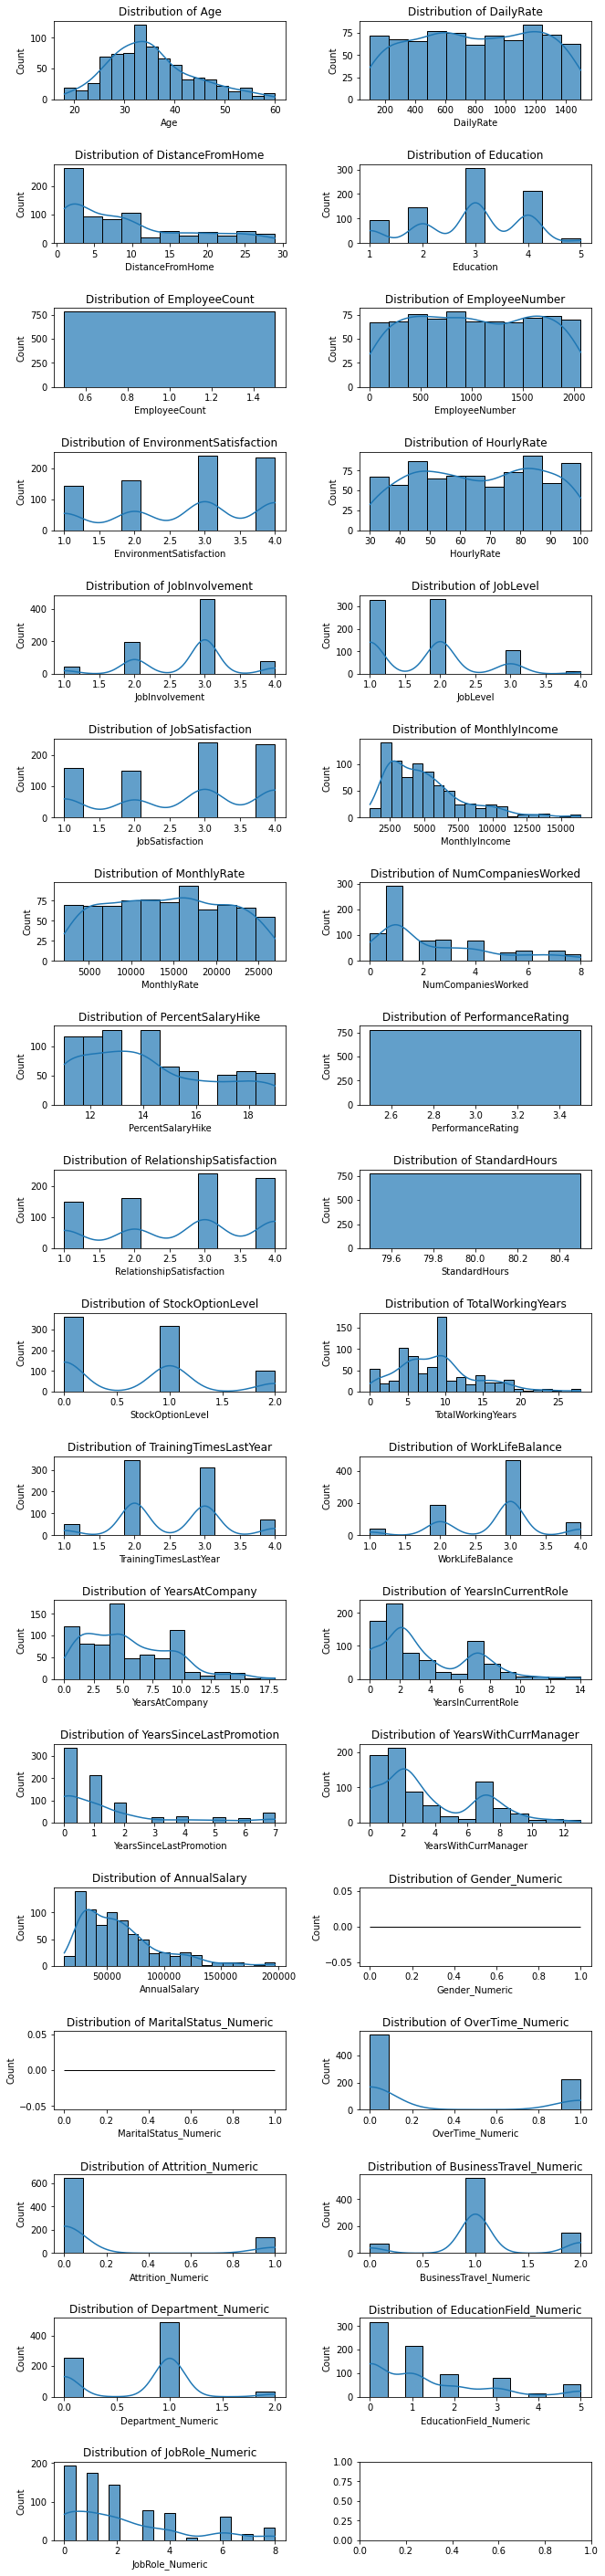

In [400]:
# visualize the distribution of key numerical variables using histograms
# List of numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for numerical variables
fig, axes = plt.subplots((len(numerical_columns)+1)//2, 2, figsize=(10, 40))
fig.tight_layout(pad=5.0)

for i, column in enumerate(numerical_columns):
    sns.histplot(df[column], ax=axes[i//2, i%2], alpha=0.7, kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {column}') 
    # set x-axis label
    axes[i//2, i%2].set_xlabel(column)

plt.show()

#### Correlation Analysis

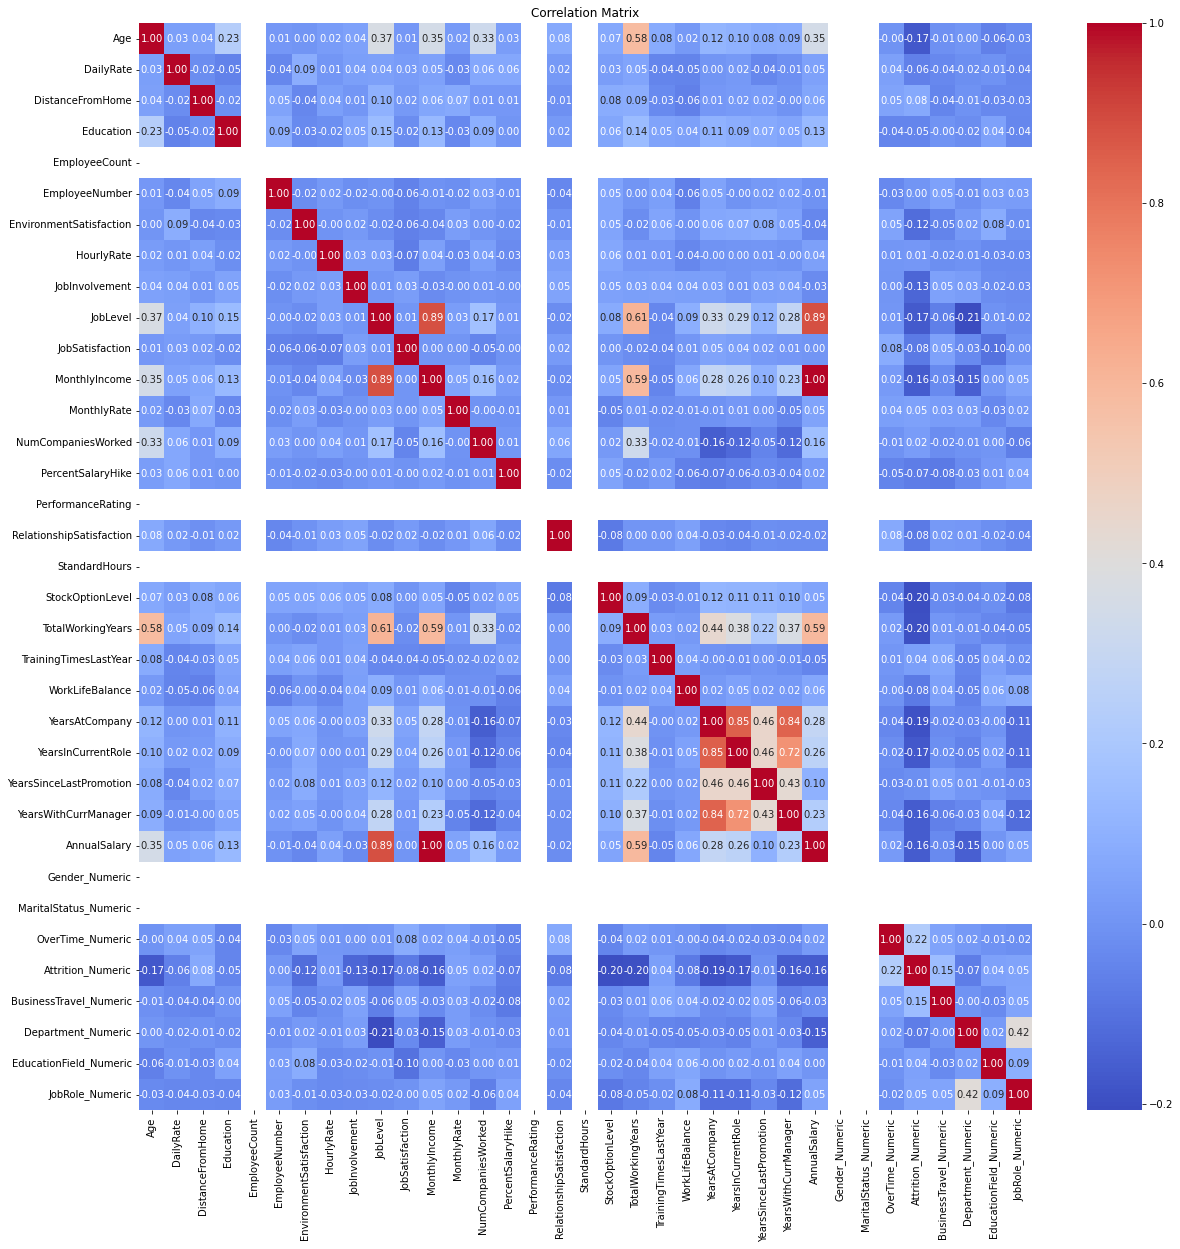

In [401]:
# correlation analysis calculate the correlation matrix
correlation_matrix = df.corr()

# plot the correlation matrix (heatmap)
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We assume the *Strong Correlation* is ($|r|>0.5$)
1. Monthly Income VS. Job Level ($r=0.89$):      
There is a strong positive correlation between monthly income and job level. This is expected as higher job levels typically come with higher salaries.
   
2. Total Working Year VS. Job Level ($r=0.61$), Total Working Yeart VS. Monthly Income ($r=0.59$):    
There is a strong positive correlation between Total Working Year, Job level and Monthly Income. This suggest that the employee who have been with the company longer are likely to have more experenise.          

3. Total Working Years vs. Age ($r=0.58$):    
There is a strong positive correlation between total working years and age. Older employees tend to have more working experience.     

4. Yeas At Company VS. Years in Current Role; and Years With Current Manager ($r=0.85, r=0.84$):      
There are is a strong postive correlation between them. Employee who have been with the company longer are lilkely to have been in their current roles for longer periods. In other words, There are not many opportunities for employees to be promoted.




### Exploratory Analysis       
##### Aggregate Cost by Department and Role


In [402]:
#Aggregate cost by department and job role
cost_summary = df.groupby(['Department', 'JobRole']).agg(TotalSalary=('MonthlyIncome', 'sum'), AverageSalary=('MonthlyIncome', 'mean'), Count = pd.NamedAgg(column='MonthlyIncome', aggfunc='count')).reset_index()
cost_summary


,Department,JobRole,TotalSalary,AverageSalary,Count
0,Human Resources,Human Resources,134540.0,4204.375000,32
1,Research & Development,Healthcare Representative,495530.0,6979.295775,71
2,Research & Development,Laboratory Technician,470834.0,3247.131034,145
3,Research & Development,Manager,57507.0,14376.750000,4
4,Research & Development,Manufacturing Director,535306.0,6862.897436,78
5,Research & Development,Research Director,234972.0,13821.882353,17
6,Research & Development,Research Scientist,580640.0,3317.942857,175
7,Sales,Manager,25495.0,12747.500000,2
8,Sales,Sales Executive,1279681.0,6596.293814,194
9,Sales,Sales Representative,157775.0,2586.475410,61


In [403]:
# Calculate the total and average salaries for comparison.
overall_average_salary = df['MonthlyIncome'].mean()
print(f'Overall average salary: {overall_average_salary}')
# Identify high-cost areas
high_cost_areas = cost_summary[cost_summary['AverageSalary'] > overall_average_salary].copy()

# Add a column to display the difference of employees in each high-cost area
high_cost_areas.loc[:, 'Difference'] = high_cost_areas['AverageSalary'] - overall_average_salary
# Display high-cost areas, sorted by average salary
high_cost_areas = high_cost_areas.sort_values(by='AverageSalary', ascending=False)
high_cost_areas



Overall average salary: 5099.204107830552


,Department,JobRole,TotalSalary,AverageSalary,Count,Difference
3,Research & Development,Manager,57507.0,14376.750000,4,9277.545892
5,Research & Development,Research Director,234972.0,13821.882353,17,8722.678245
7,Sales,Manager,25495.0,12747.500000,2,7648.295892
1,Research & Development,Healthcare Representative,495530.0,6979.295775,71,1880.091667
4,Research & Development,Manufacturing Director,535306.0,6862.897436,78,1763.693328
8,Sales,Sales Executive,1279681.0,6596.293814,194,1497.089707


The result show that the high-cost areas are the healthcare representativem and manufacturing director in research & development; sales executive in sales departmen.They exceed the overall average salary by 2155.97, 1710.27, and 1647.45, respectively.      
##### Factor Analysis

[4.57998610e+00 3.48283205e+00 2.32265848e+00 2.09894681e+00
 1.82514364e+00 1.57579688e+00 1.44473580e+00 1.35563840e+00
 1.29199542e+00 1.23196863e+00 1.20077867e+00 1.18810736e+00
 1.14460629e+00 1.13187684e+00 1.03839081e+00 1.02882870e+00
 9.80999795e-01 9.40611278e-01 9.19223895e-01 9.01213214e-01
 8.70426762e-01 8.31988668e-01 8.11647055e-01 7.64543975e-01
 6.79062772e-01 6.49814272e-01 5.87519609e-01 5.57711354e-01
 3.59511443e-01 2.73796485e-01 2.35020018e-01 2.16607843e-01
 1.63003971e-01 1.15203152e-01 9.55074660e-02 8.62328080e-02
 1.37719300e-02 4.29136372e-03 1.25420917e-16]


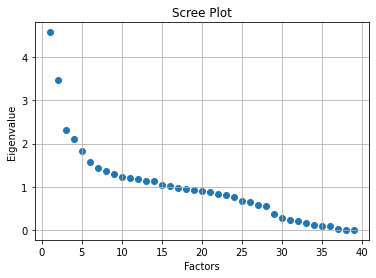

In [404]:
# select the independent variables for regression analysis, (MonthlyIncome, EnvironmentSatisfaction,Age, DistanceFromHome, YearsAtCompany, Education, JobLevel, WorkLifeBalance, YearsInCurrentRole, TrainingTimesLastYear, PercentSalaryHike, StockOptionLevel, jobsatisfaction, JobInvolvement, PerformanceRating, JobRole, Department,gender, MaritalStatus, OverTime, BusinessTravel, EducationField, department, numcompaniesworked, totalworkingyears, yearswithcurrmanager, yearssincelastpromotion, yearssincelastraise)
regression_data = df[['MonthlyIncome', 'EnvironmentSatisfaction', 'Age', 'DistanceFromHome', 'YearsAtCompany', 'Education', 'JobLevel', 'WorkLifeBalance', 'YearsInCurrentRole', 'TrainingTimesLastYear', 'PercentSalaryHike', 'StockOptionLevel', 'JobSatisfaction', 'JobInvolvement', 'PerformanceRating', 'JobRole', 'Gender', 'MaritalStatus', 'OverTime', 'BusinessTravel', 'EducationField', 'Department', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsWithCurrManager', 'YearsSinceLastPromotion']]   

# Convert categorical variables to dummy variables
regression_data = pd.get_dummies(regression_data, columns=['JobRole', 'Department', 'Gender', 'MaritalStatus', 'OverTime', 'BusinessTravel', 'EducationField'], drop_first=True)

# Create a FactorAnalyzer object
fa = factor.FactorAnalyzer()

# remove columns where standard deviation is zero
regression_data = regression_data.loc[:, regression_data.std() != 0]

# Fit the FactorAnalyzer object to the data
fa.fit(regression_data)


#chechk eigenvalues to determine the number of factors to retain. print them and the column name that match them.
eigen_values, vectors = fa.get_eigenvalues()
print(eigen_values)

#polt the eigenvalues
plt.scatter(range(1, regression_data.shape[1]+1), eigen_values) 
#add title and labels
plt.title('Scree Plot') 
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()



The scree plot helps determine the optimal number of factors by plotting the Eigenvalues. Factors with Eigenvalues greater than 1 are typically retained. In the above figure we retain 15 factors 

In [405]:
# Extract the factor loadings
# Select the number of factors based on the Eighenvalues and scree plot. we select the favtors with eigenvalues greater than 1.
fa = factor.FactorAnalyzer(n_factors=5, rotation='varimax')
fa.fit(regression_data)

# Get the factor loadings
factor_loadings = fa.loadings_
factor_loadings_df = pd.DataFrame(factor_loadings, index=regression_data.columns)
print("Factor Loadings:\n", factor_loadings_df)




Factor Loadings:
                                           0         1         2         3  \
MonthlyIncome                      0.263014  0.870131  0.102961  0.040317   
EnvironmentSatisfaction           -0.011360 -0.039365  0.082939  0.012838   
Age                                0.049343  0.499777  0.018961  0.090376   
DistanceFromHome                   0.010156  0.068781  0.000266  0.087126   
YearsAtCompany                     0.079648  0.183813  0.958802  0.067579   
Education                          0.084190  0.172282  0.056554  0.029405   
JobLevel                           0.324253  0.856531  0.152034  0.047132   
WorkLifeBalance                    0.096847  0.031277  0.019340 -0.004030   
YearsInCurrentRole                 0.084596  0.158141  0.843580  0.066038   
TrainingTimesLastYear              0.026083 -0.020742  0.002893 -0.045312   
PercentSalaryHike                  0.002191  0.020437 -0.073675  0.047648   
StockOptionLevel                   0.037483  0.016376  0.0

##### Regression Analysis

In [406]:
# based on the factor loadings, we can select the 5 main factors that explain the variance in the data 
selected_columns = ['MonthlyIncome', 'EnvironmentSatisfaction', 'Age', 'DistanceFromHome', 'YearsAtCompany', 'Education', 'JobLevel', 'WorkLifeBalance', 'YearsInCurrentRole', 'TrainingTimesLastYear', 'PercentSalaryHike', 'StockOptionLevel', 'JobSatisfaction', 'JobInvolvement',  'NumCompaniesWorked', 'TotalWorkingYears','YearsWithCurrManager', 'YearsSinceLastPromotion']

# prepare the data for regression analysis
x = regression_data[selected_columns]  
y = df['AnnualSalary']

# add a constant to the predictor variables (required for statsmodels regression)
x = sm.add_constant(x)

# fit the regression model
model = sm.OLS(y, x).fit()

print(model.summary())

# Display the regression results and add stars to significat P-values
results_summary = model.summary()
regression_as_html = results_summary.tables[1].as_html()
df_results = pd.read_html(regression_as_html, header=0, index_col=0)[0]
# Function to add stars to significant P-values
def add_stars(p_value):
    if p_value < 0.05:
        return f'{p_value:.4f}***'
    elif p_value < 0.1:
        return f'{p_value:.4f}*'
    else:
        return f'{p_value:.4f}'
    
# Adding stars to significant P-values
df_results['P>|t|'] = df_results['P>|t|'].apply(lambda x: f"{x:.3f}{add_stars(x)}")
print(df_results)






                            OLS Regression Results                            
Dep. Variable:           AnnualSalary   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.379e+30
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:52:18   Log-Likelihood:                 16983.
No. Observations:                 779   AIC:                        -3.393e+04
Df Residuals:                     760   BIC:                        -3.384e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    7

- *R-squared*: This is the proportion of variance in the dependent variable that is predictable from the independent variables. Here, it's 1.000, which indicates a perfect fit. However, such a high value can be suspicious and might indicate overfitting.
- *Adj. R-squared*: Adjusted R-squared accounts for the number of predictors in the model and adjusts for the degrees of freedom. It’s also 1.000, reinforcing the perfect fit indication.
- *F-statistic*: This tests the overall significance of the model. A value of 7.379e+30 is extremely high, and the associated Prob (F-statistic) of 0.00 suggests the model is statistically significant.
- AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These are measures used to compare models; lower values indicate a better fit.

##### Diagnostic Statistics
- *Omnibus*: This is a test for the skewness and kurtosis of the residuals. A value of 208.389 with a p-value of 0.000 indicates non-normality of residuals.
- *Durbin-Watson*: This tests for autocorrelation in the residuals. A value close to 2 indicates no autocorrelation. Here, 0.600 suggests positive autocorrelation.
- *Jarque-Bera (JB)*: This tests whether the residuals have the skewness and kurtosis matching a normal distribution. A value of 490.638 with a p-value close to 0 indicates the residuals are not normally distributed.
- *Skew*: This measures the asymmetry of the residuals. A value of 1.418 indicates positive skewness.
- *Kurtosis*: This measures the peakedness of the residuals. A value of 5.659 indicates more outliers than the normal distribution.

In [407]:
# the above regression model show that the residuals are not normally distributed, how to fix this?
# we can use the log transformation to fix the residuals
# Log-transform the dependent variable
y_log = np.log(y)
# how to reduce the multicollinearity in the model?
# we can use the VIF to reduce the multicollinearity in the model
# Calculate the VIF for each predictor variable
vif = pd.DataFrame()
vif["features"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vif)

# Remove the predictor variable with the highest VIF
x = x.drop('YearsAtCompany', axis=1)  
# Fit the regression model with the log-transformed dependent variable and the reduced predictor variables
model_log = sm.OLS(y_log, x).fit()
# Display the regression results
print(model_log.summary())



                   features         VIF
0                     const  107.415764
1             MonthlyIncome    4.864403
2   EnvironmentSatisfaction    1.031334
3                       Age    1.673433
4          DistanceFromHome    1.035460
5            YearsAtCompany    6.676534
6                 Education    1.090046
7                  JobLevel    5.144766
8           WorkLifeBalance    1.028822
9        YearsInCurrentRole    3.708333
10    TrainingTimesLastYear    1.027161
11        PercentSalaryHike    1.018631
12         StockOptionLevel    1.039754
13          JobSatisfaction    1.018885
14           JobInvolvement    1.017278
15       NumCompaniesWorked    1.321864
16        TotalWorkingYears    2.753517
17     YearsWithCurrManager    3.552527
18  YearsSinceLastPromotion    1.322124
                            OLS Regression Results                            
Dep. Variable:           AnnualSalary   R-squared:                       0.918
Model:                            OLS   Ad

  Principal Component  Eigenvalue  Explained Variance Ratio  \
0                 PC1    4.585871                  0.117435   
1                 PC2    3.487300                  0.089303   
2                 PC3    2.324977                  0.059538   
3                 PC4    2.099772                  0.053771   
4                 PC5    1.826279                  0.046768   

   Cumulative Explained Variance  
0                       0.117435  
1                       0.206739  
2                       0.266277  
3                       0.320048  
4                       0.366816  


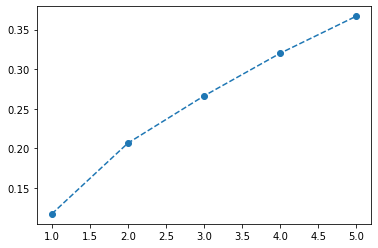

In [422]:
# Perform PCA
pca = PCA(n_components=5)
pca.fit(regression_data)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(explained_variance_ratio)+1), cumulative_variance, marker='o', linestyle='--')

# Extract eigenvalues (the amount of variance each PC explains)
eigenvalues = pca.explained_variance_

# Extract explained variance ratio (percentage of variance explained by each PC)
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create a summary table
summary_table = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
    'Eigenvalue': eigenvalues,
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': cumulative_variance
})

print(summary_table)



